# Colours project

In [1]:
from PIL import Image #Python Imaging Library

import sys

import os

import numpy as np

import pandas as pd

from sklearn.cluster import KMeans

from kneed import KneeLocator

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
def RGB_histogram(values, name):
    '''
    RGB Histogram
    
    - Description:
        Creates and saves an histogram for the frequency of RGB contributions in the image.
    
    - Parameters:
        values: the pixels RGB data as a list of tuples of length 3 (R, G and B)
        name: the name of the output image
    '''
    
    if not os.path.isdir("histograms"):
        os.makedirs("histograms")
        
    f = plt.figure(figsize=(15,10))
    plt.grid()
    color = ('firebrick','mediumseagreen','royalblue')
    for i,col in enumerate(color):
        plt.hist(np.array(values)[:,i], color = col, histtype = 'stepfilled', 
                     bins = 256, alpha = 0.6)
    plt.xlim([0,256])
    plt.title("RGB contributions for "+ name)
    plt.ylabel("Frequency")
    plt.xlabel("Contribution to the pixels")
    
    plt.savefig("histograms/RGB_contribution_" + name + ".png")

In [3]:
def multiple_images(images, outputname):
    '''
    Multiple Images
    
    - Description:
        Combines several images side by side.
    
    - Paramaters:
        images: images data
        outputname: output file name
    '''
    
    widths, heights = zip(*(i.size for i in images))
    total_width = sum(widths)
    max_height = max(heights)
    
    new_im = Image.new('RGB', (total_width, max_height))
    
    x_offset = 0
    
    for im in images:
        new_im.paste(im, (x_offset,0))
        x_offset += im.size[0]
        new_im.save(outputname +'.jpg')

In [4]:
def RGB_image(values, outputname, img, size):
    '''
    RGB Image
    
    - Description:
        Creates a composite side by side of the image and its RGB contributions
        
    - Parameters:
        values: image RGB data as a list of tuples of length 3 (R, G, B)
        outputname: output file name
        img: image data
        size: image size (width and height)
    '''
    
    if not os.path.isdir("RGBcomposites"):
        os.makedirs("RGBcomposites")
        
    r = [(d[0], 0, 0) for d in values]
    g = [(0, d[1], 0) for d in values]
    b = [(0, 0, d[2]) for d in values]
    
    width, height = size
    
    new_im1 = Image.new('RGB', (width, height))
    new_im2 = Image.new('RGB', (width*3, height))
    x_offset = 0
    for j in [r, g, b]:
        new_im1.putdata(j)
        new_im2.paste(new_im1, (x_offset,0))
        x_offset = x_offset + width
        
    I = [img, new_im2]
    final = multiple_images(I, "RGBcomposites/" + outputname)
    return(final)

In [5]:
def colors_plot(colors, size, img, name, pixel_label):
    '''
    Palette plotter
    
    - Description: 
        Given certain RGB value or values, plots side by side an image, those RGB values and the image using the RGB values
        
    - Parameters:
        colors: list of RGB values to plot
        size: image size (width and height)
        img: image data
        name: name of the image
    '''
    
    if not os.path.isdir("ColorPalette"):
        os.makedirs("ColorPalette")
    
    # Making the sample colors
    sample = []
    number = len(colors)
    
    width, height = size
    
    for c in colors:
        sample = sample + ([c] * (round(width*height/number)-1))
        
    new_img = Image.new('RGB', (width, height))
    new_img.putdata(sample)
    
    # Making the image using the sample colors
    new_img2 = Image.new('RGB', (width, height))
    A = pixel_label.tolist()
    for i in range(0, len(A)):
        for j in range(0, len(Imagen.colors)):
            if A[i] == j:
                A[i] = Imagen.colors[j]
    new_img2.putdata(A)
    
    # Put everything together side by side
    images = [img, new_img, new_img2]
    widths, heights = zip(*(i.size for i in images))
    total_width = sum(widths)
    max_height = max(heights)
    new_im = Image.new('RGB', (total_width, max_height))
    x_offset = 0
    for im in images:
        new_im.paste(im, (x_offset,0))
        x_offset += im.size[0]
        
    new_im.save('ColorPalette/ColorPalette_' + name +'.jpg')

In [6]:
def ElbowCurve(min_clusters, max_clusters, X):
    '''
    Elbow Curve
    
    - Description:
        Plots the score for different numbers of clusters, helping the user to determine the ideal cluster quantity
    
    - Parameters:
        min_clusters: minimum number of clusters to test
        max_clusters: maximum numbert of clusters to test
        X: the dataset
    
    '''
    Nc = range(min_clusters, max_clusters)
    kmeans = [KMeans(n_clusters=i) for i in Nc]
    score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
    
    x = range(1, len(score)+1)
    kn = KneeLocator(x, score, curve = 'concave', direction = 'increasing', online = True, S = 3)
    
    plt.figure(figsize=(5,5))
    plt.plot(Nc,score)
    plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
    plt.xlim([min_clusters-1,max_clusters])
    plt.xlabel('Number of Clusters')
    plt.ylabel('Score')
    plt.title('Elbow Curve')
    plt.grid()
    plt.show()
    return(kn.knee)

In [7]:
def ColorClusteringSKlearn(pixel_values, clusters):
    '''
    Color Clustering
    
    - Description:
        Using K-means clustering extracts from the image as many principals colors as clusters stated.
        Used random_state = 42
        Returns the centroids of the clusters and the label for each pixel (i.e., the value of the centroid for each pixel)
        
    - Parameters:
        pixel_values: image RGB data for every pixel
        clusters: number of desired clusters
    '''
    X = np.array(pixel_values)
    
    kmeans = KMeans(n_clusters=clusters, random_state=42).fit(X)
    
    centroids = kmeans.cluster_centers_
    centroids = np.around(centroids)
    centroids = centroids.astype(int)
    centroids = tuple(map(tuple, centroids))
    
    labels = kmeans.predict(X)
    
    return(centroids, labels)

In [8]:
class ImageAnalizer(object):
    
    def __init__(self, path):
        self.path = path
        self.name = path.split('/')[1].split(".", 1)[0]
        self.img = Image.open(path)
        self.pix = self.img.load()
        self.size = self.img.size
        self.total_pixels = self.size[0]*self.size[1]
        self.pixel_values = list(self.img.getdata())
        self.colors = np.NaN
        self.pixel_label = np.NaN
        
    def RGB_graph(self):
        return(RGB_histogram(self.pixel_values, self.name))
    
    def RGB_composite(self):
         return(RGB_image(self.pixel_values, 'RGB_composite_' + self.name, self.img, self.size))
        
    def Color_palette(self, num_clusters):
        self.colors, self.pixel_label = ColorClusteringSKlearn(self.pixel_values, num_clusters)
        return(colors_plot(self.colors, self.size, self.img, self.name, self.pixel_label))


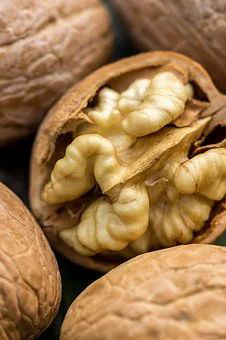

In [9]:
Imagen = ImageAnalizer("Imgs/nuez.jpg")
Imagen.img

In [10]:
Imagen.RGB_composite()

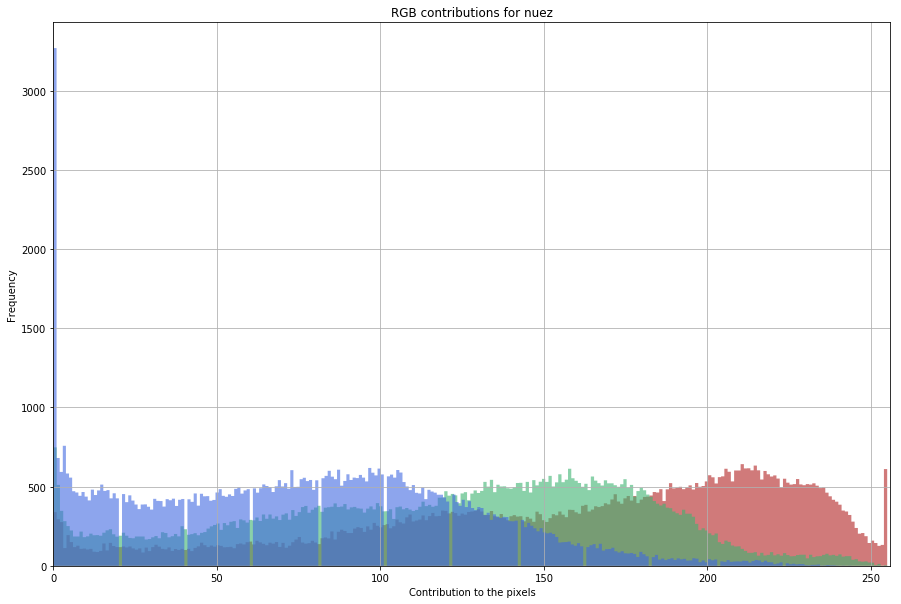

In [11]:
Imagen.RGB_graph()

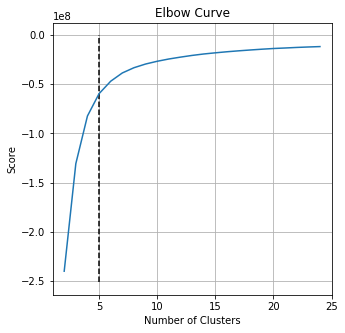

In [12]:
maxclusters = 25
clusters = ElbowCurve(2, maxclusters, Imagen.pixel_values)

In [13]:
Imagen.Color_palette(clusters)

In [14]:
def SaveClustersInfo(Name, Colors, Labels, Pixels, max_clusters):
    
    # csv file with the percentage of pixels for each principal color
    df1 = pd.read_csv("ColorClusterPercentage.csv")
    
    percentage = []
    for i in range(0, len(Colors)):
        A = round((np.sum(Labels==i)/Pixels)*100)
        percentage = percentage + [A]
    
    add = []
    if len(percentage)<max_clusters:
        remain = max_clusters-len(percentage)
        add = [np.NaN]*remain
    percentage = percentage + add
    
    df1[Name] = percentage
    df1.to_csv(r'ColorClusterPercentage.csv', index = False)
    
    # csv file with the principal colors in RGB
    df2 = pd.read_csv("ColorClusterRGB.csv")
    
    add = []
    if len(Colors)<max_clusters:
        remain = max_clusters-len(Imagen.colors)
        add = [np.NaN]*remain
    Colors = Colors + tuple(add)
    
    df2[Name] = Colors
    df2.to_csv(r'ColorClusterRGB.csv', index = False)
    
    
    

In [15]:
SaveClustersInfo(Imagen.name, Imagen.colors, Imagen.pixel_label, Imagen.total_pixels, 30)

In [30]:
from os import walk

f = []
for (dirpath, dirnames, filenames) in walk("Imgs"):
    for file in filenames:
        if file.endswith(".jpg"):
            f.extend([file])

In [32]:
f

['teal.jpg',
 'denim.jpg',
 'ajo.jpg',
 'mango.jpg',
 'av.jpg',
 'mallows.jpg',
 'but.jpg',
 'shining.jpg',
 'cat.jpg',
 'siames.jpg',
 'cake.jpg',
 'zaan.jpg',
 'sp.jpg',
 'mousse.jpg',
 'peach2.jpg']

In [14]:
fullpath = os.path.join(dirpath, filenames[0])

hazelnuts.jpg


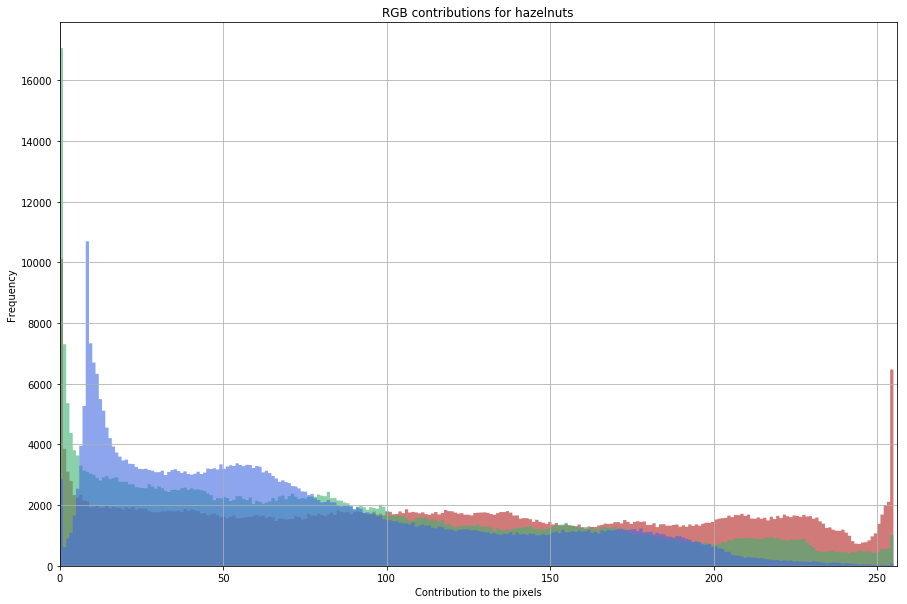

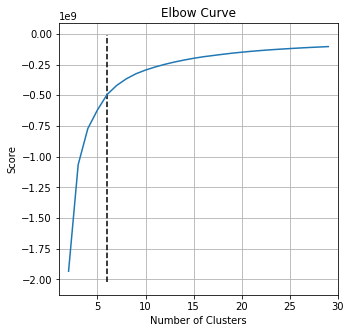

tibet.jpg


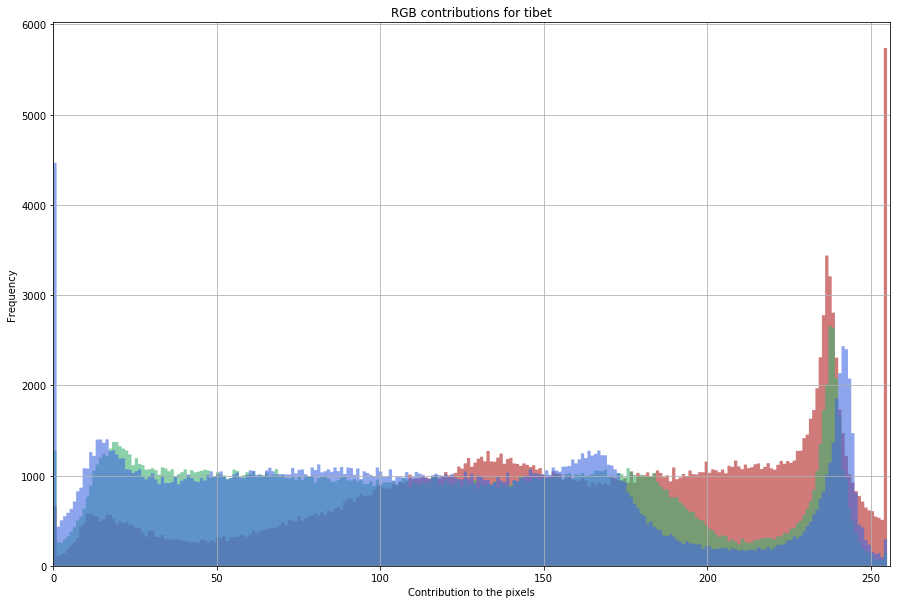

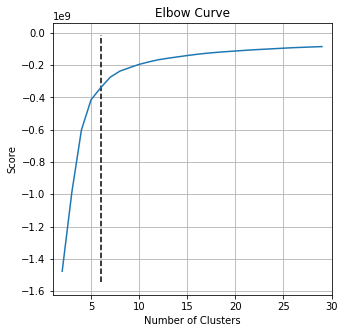

morr.jpg


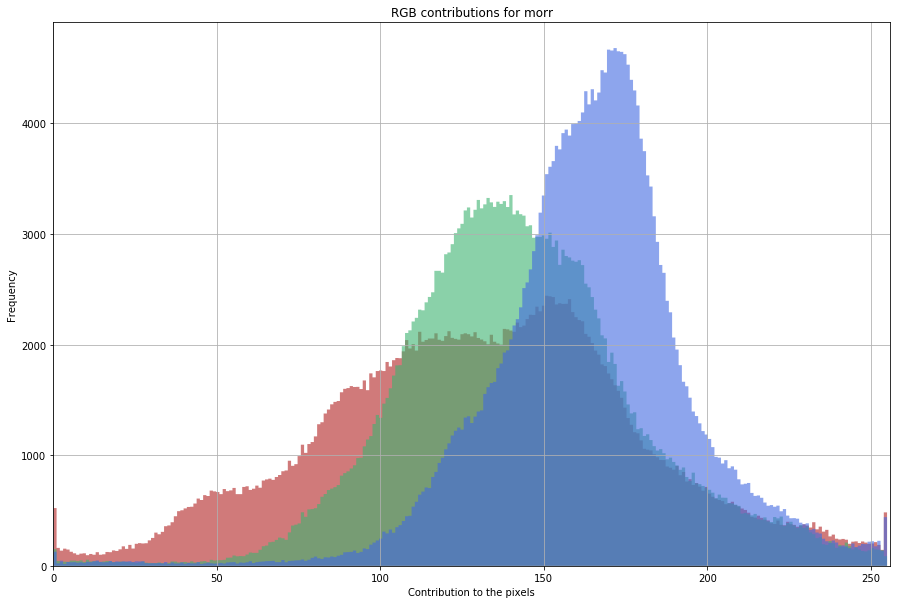

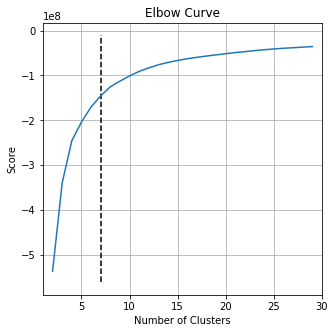

tropical.jpg


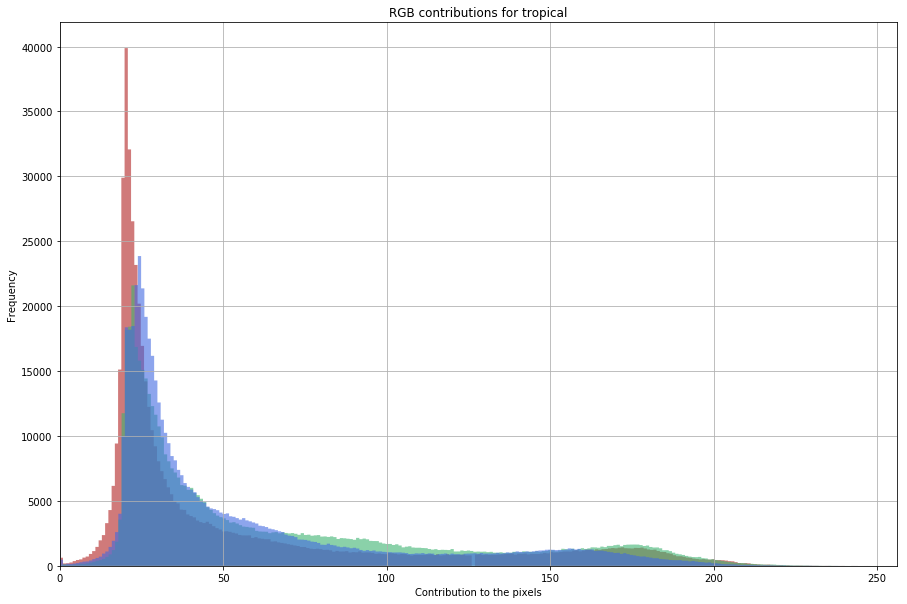

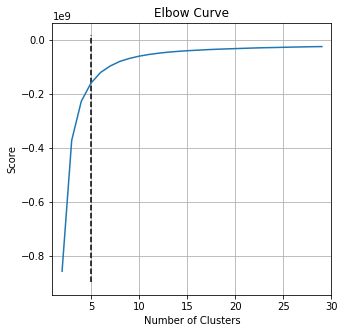

throne.jpg


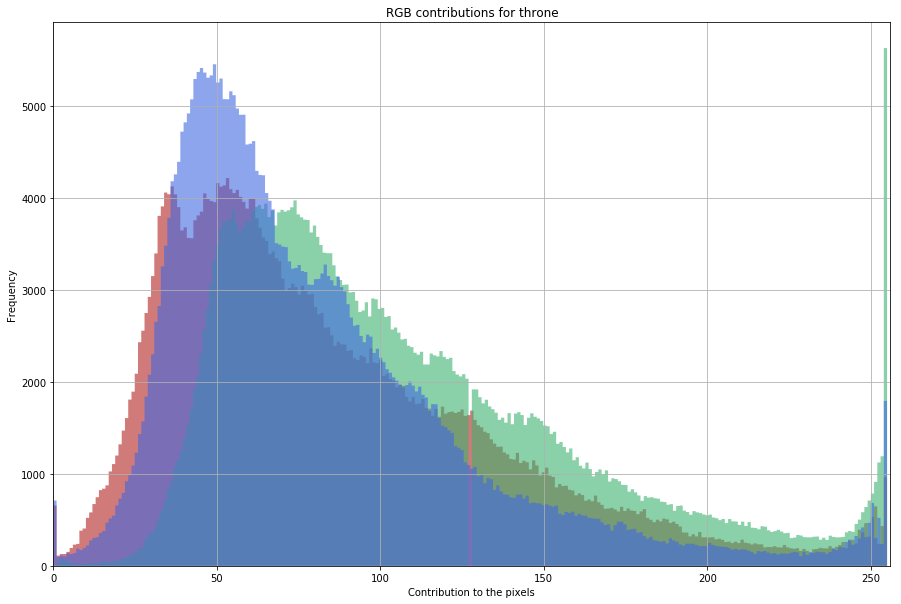

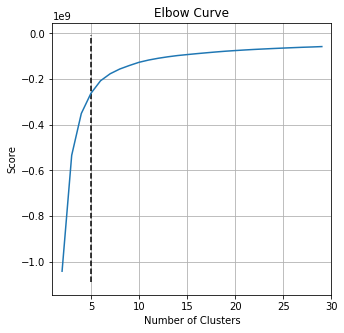

kies.jpg


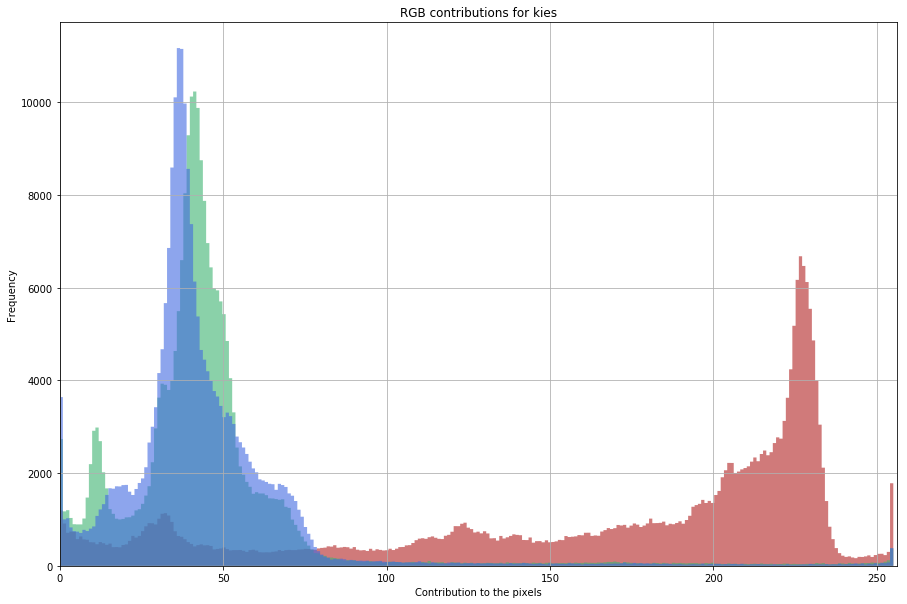

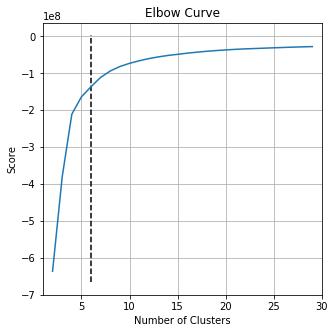

bjork.jpg


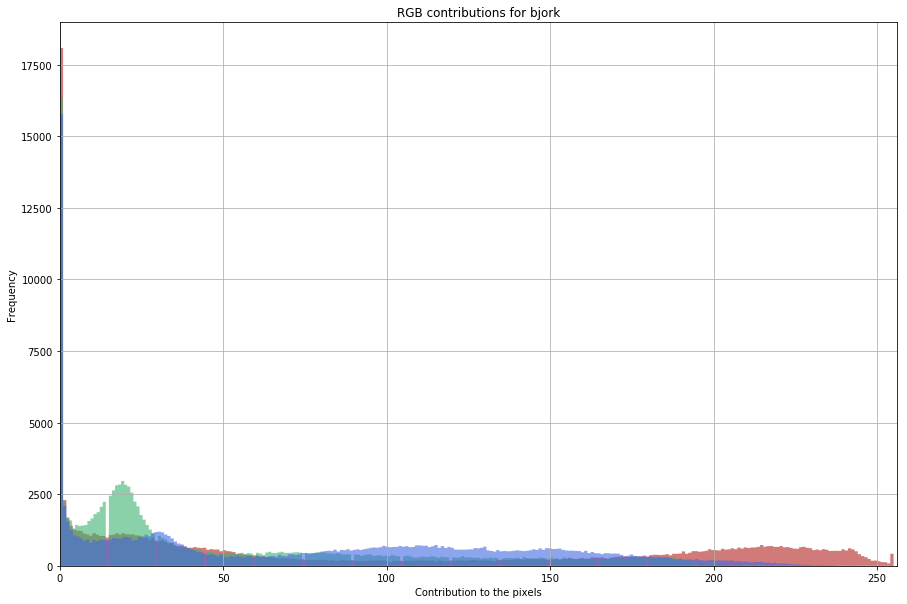

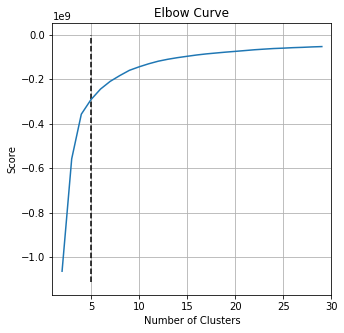

matcha.jpg


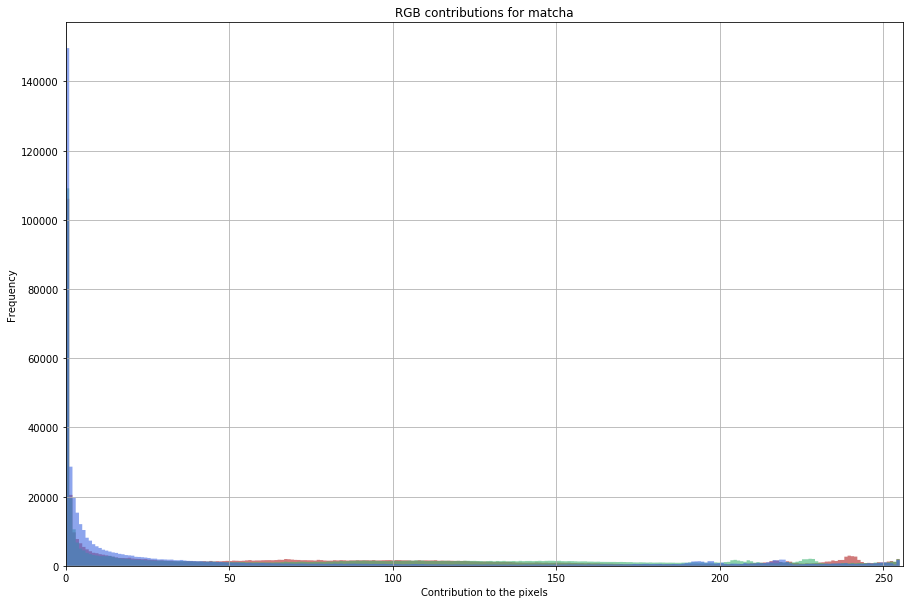

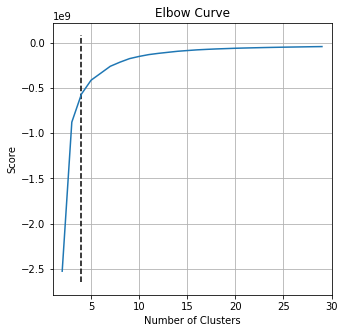

gf.jpg


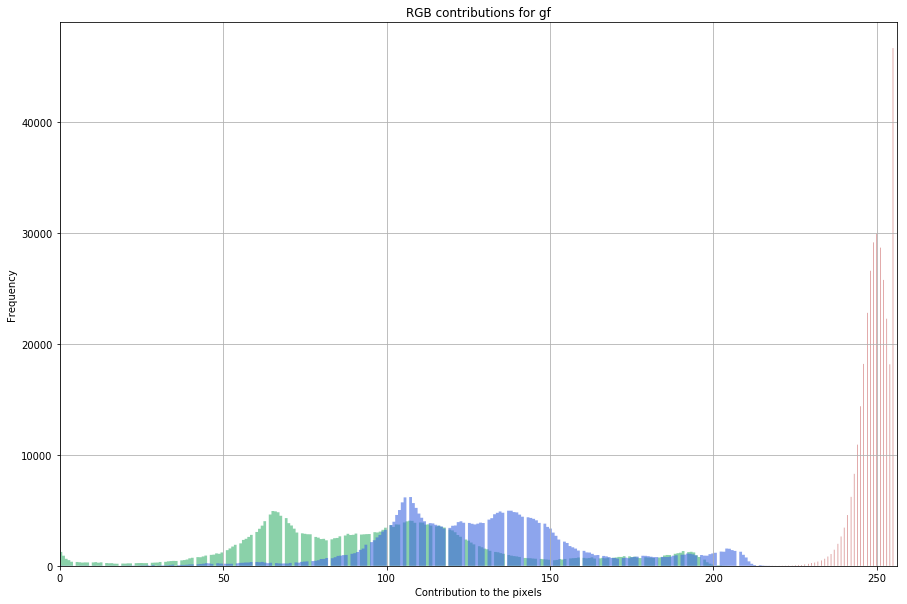

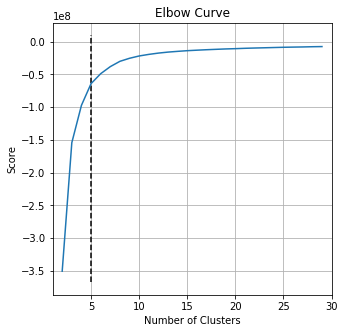

cacti.jpg


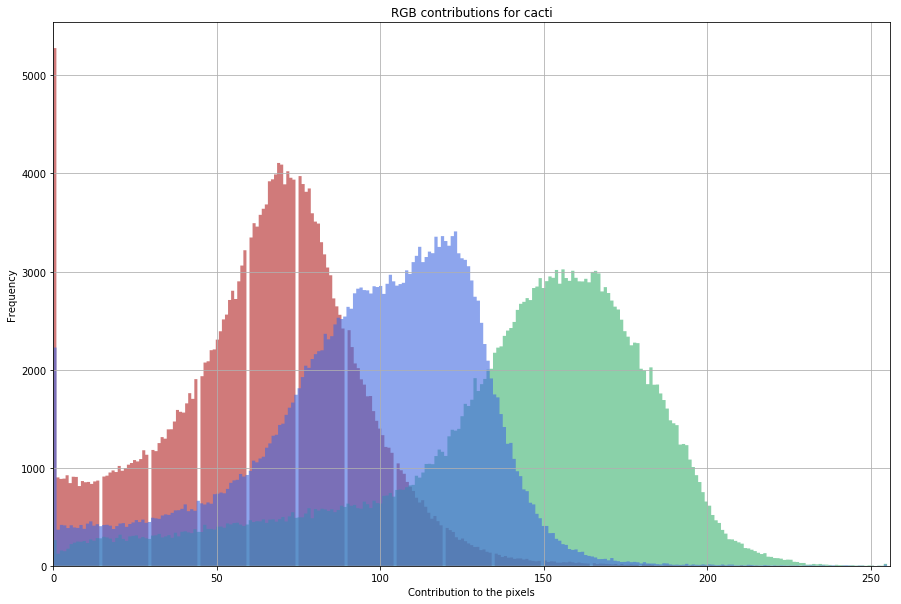

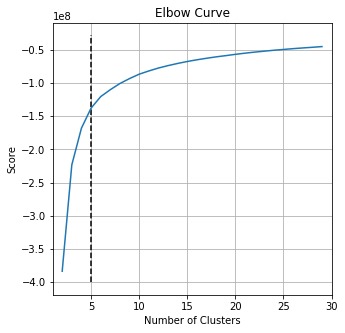

reflection.jpg


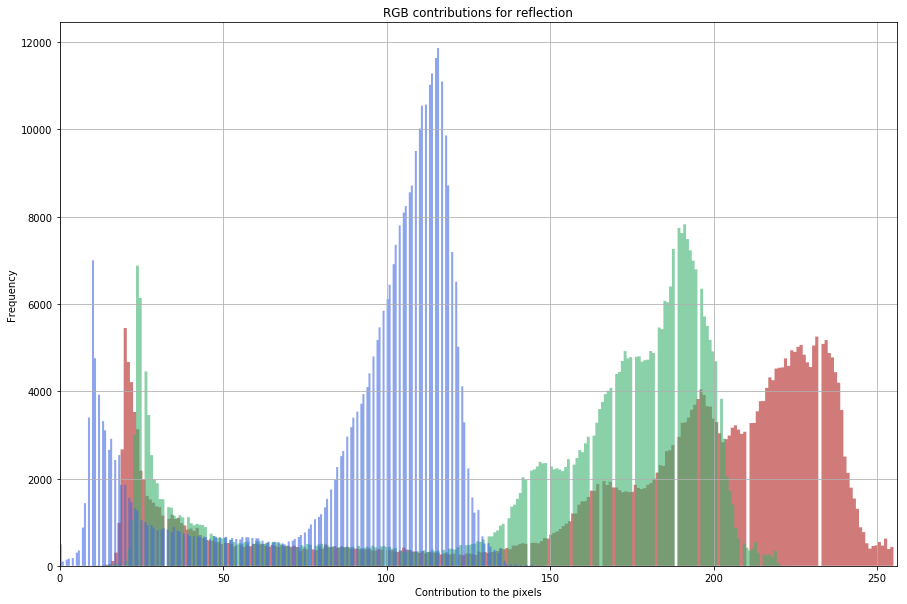

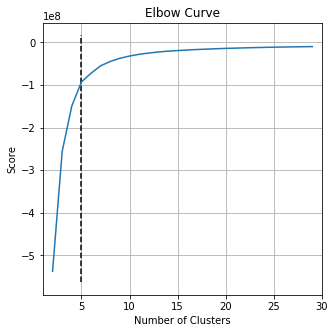

bal.jpg


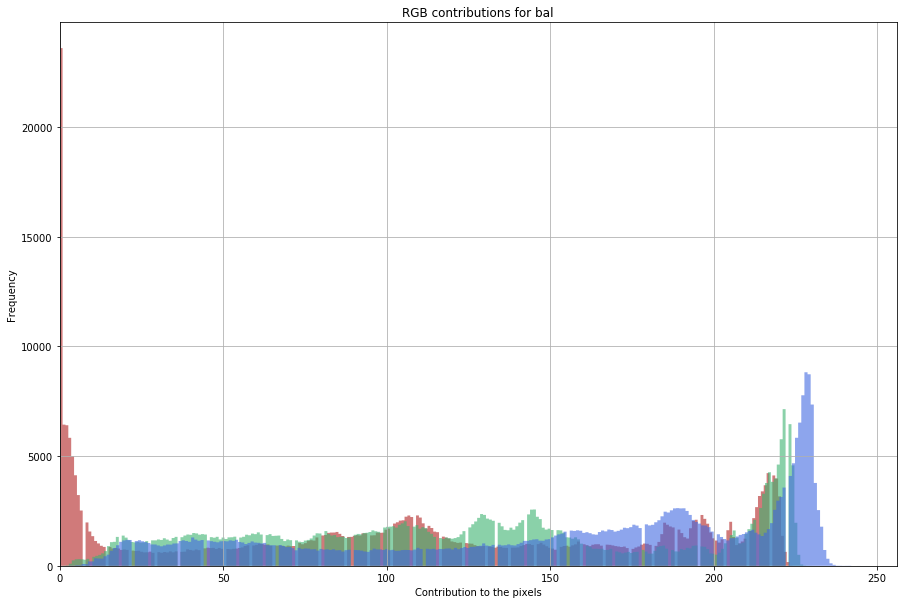

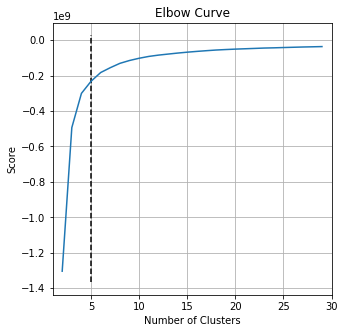

window.jpg


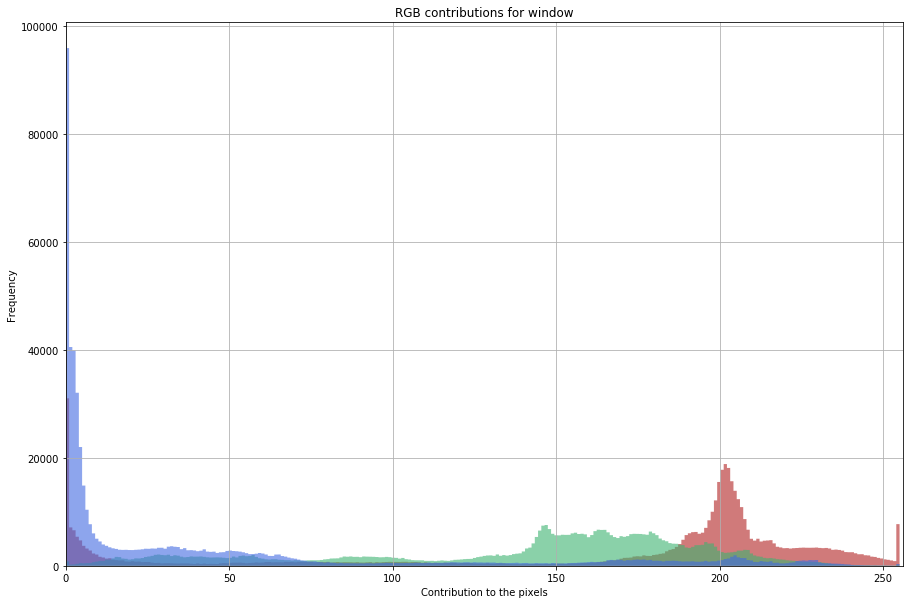

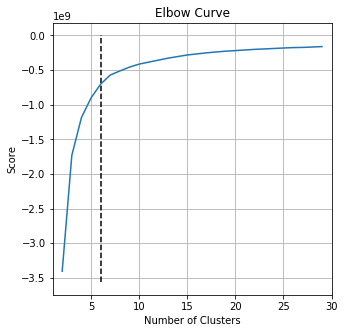

sea.jpg


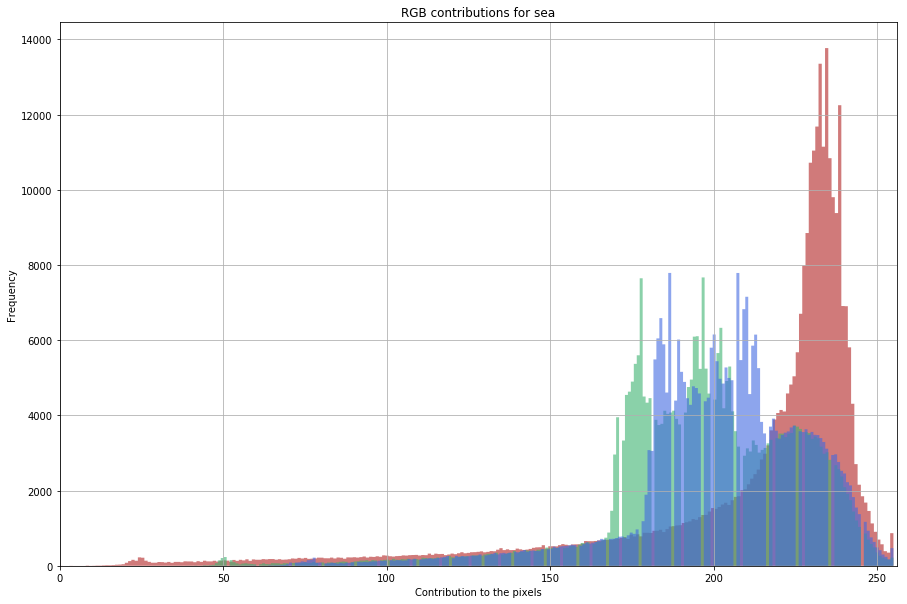

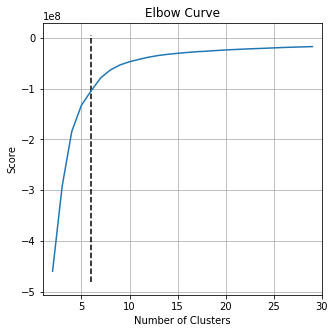

holo.jpg


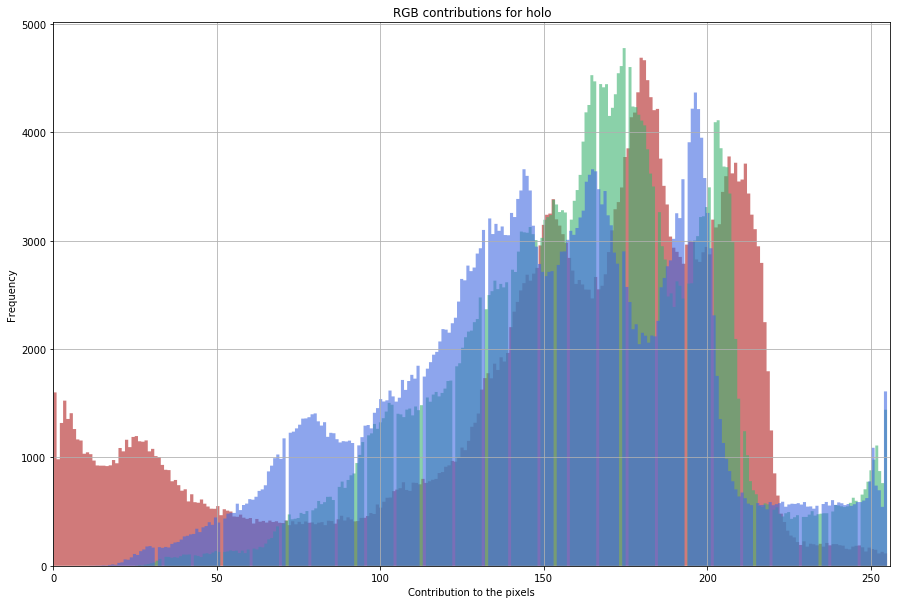

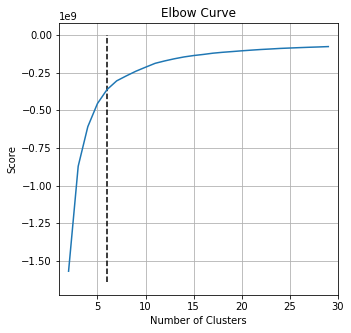

pf.jpg


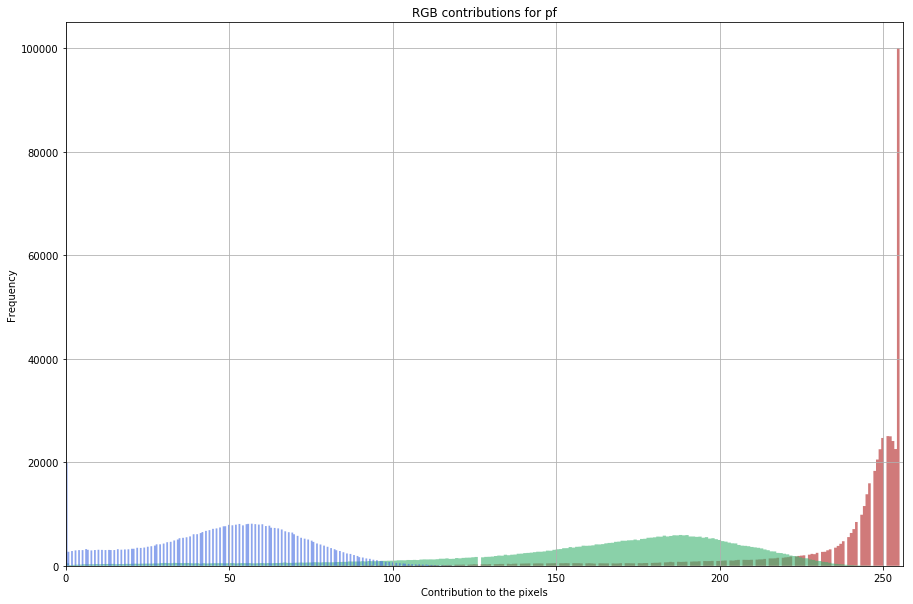

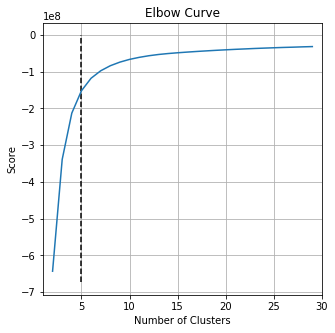

bee.jpg


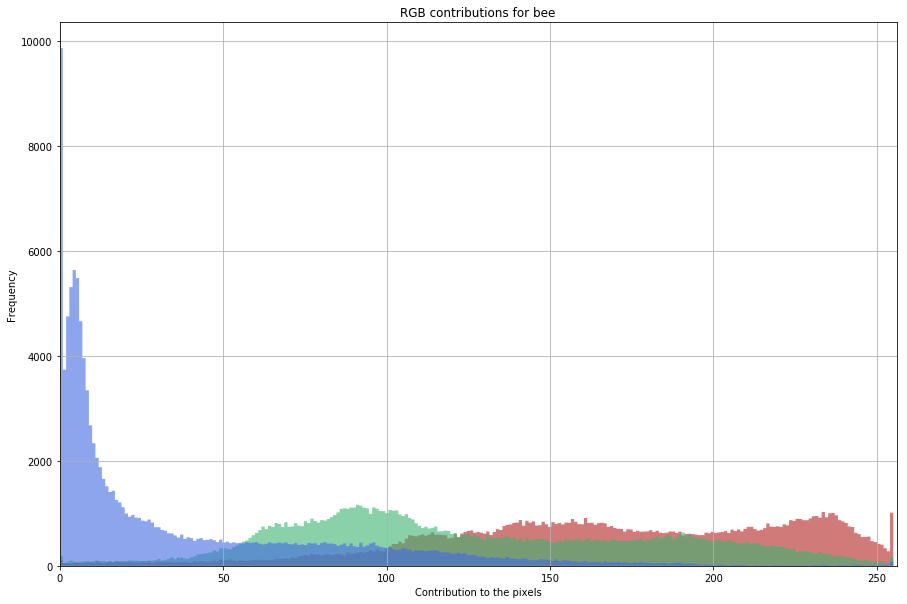

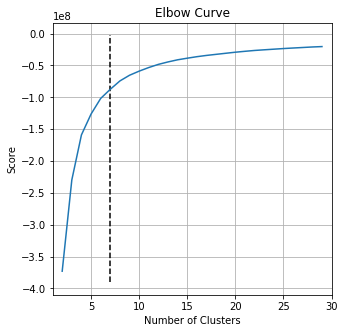

net.jpg


KeyboardInterrupt: 

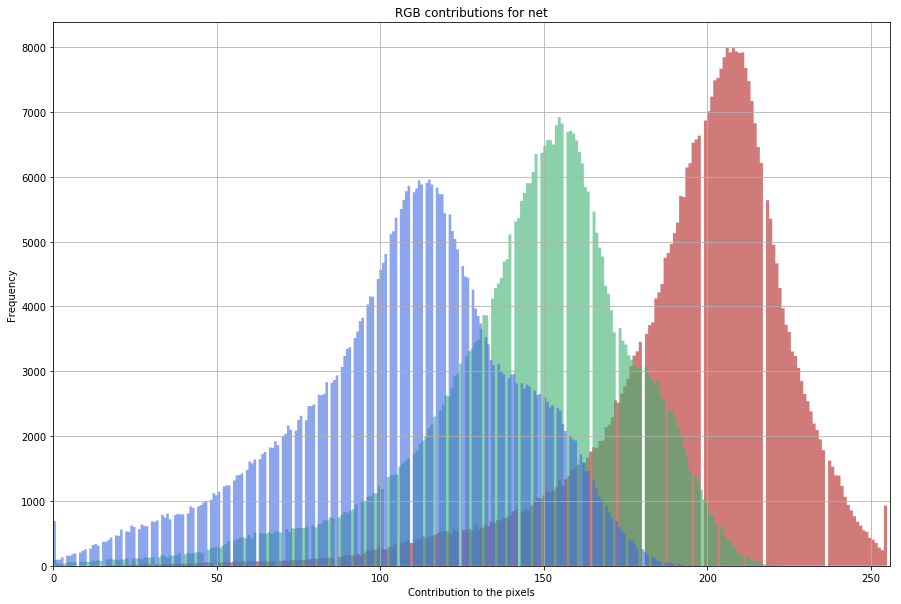

In [14]:
for i in filenames:
    print(i)
    fullpath = os.path.join(dirpath, i)
    Imagen = ImageAnalizer(fullpath)
    Imagen.RGB_composite()
    Imagen.RGB_graph()
    maxclusters = 30
    clusters = ElbowCurve(2, maxclusters, Imagen.pixel_values)
    Imagen.Color_palette(clusters)
    SaveClustersInfo(Imagen.name, Imagen.colors, Imagen.pixel_label, Imagen.total_pixels, maxclusters)
    